In [1]:
import numpy as np
import cv2
from pathlib import Path
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [2]:
lidar_dir = Path("/home/julia/workspace/datasets/2011_09_26/2011_09_26_drive_0048_sync/velodyne_points/data")
image_path = Path("/home/julia/workspace/datasets/2011_09_26/2011_09_26_drive_0048_sync/image_02/data/0000000000.png")

In [3]:
projection_matrix = np.array([
    [613.040929, -718.575854, -2.950028, -124.072003],
    [182.759005,   12.239512, -718.988552, -101.607812],
    [0.999893,     0.004697,    0.013829,   -0.269120]
])

In [4]:
def load_velodyne_points(index: int) -> np.ndarray:
    bin_path = lidar_dir / f"{index:010d}.bin"
    with open(bin_path, 'rb') as f:
        return np.fromfile(f, dtype=np.float32).reshape(-1, 4)

def filter_lidar_points(points: np.ndarray) -> np.ndarray:
    return points[points[:, 0] > 0]

def cluster_lidar_points(points: np.ndarray, eps=0.5, min_samples=10):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points[:, :3])
    labels = clustering.labels_
    clusters = [points[labels == label] for label in set(labels) if label != -1]
    return clusters

def get_cluster_centroids(clusters):
    return np.array([np.mean(cluster[:, :3], axis=0) for cluster in clusters])

def project_points(points: np.ndarray, proj_matrix: np.ndarray):
    hom = np.hstack((points, np.ones((points.shape[0], 1))))
    cam_pts = proj_matrix @ hom.T
    return (cam_pts[:2] / cam_pts[2]).T

In [5]:
image = cv2.imread(str(image_path))
lidar_points = filter_lidar_points(load_velodyne_points(0))
clusters = cluster_lidar_points(lidar_points)
centroids = get_cluster_centroids(clusters)
projected = project_points(centroids, projection_matrix)

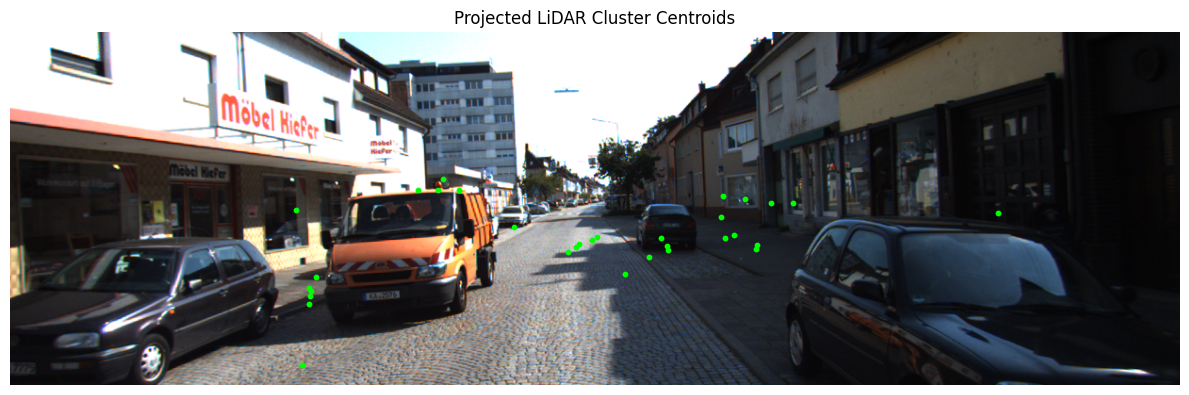

In [6]:
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.scatter(projected[:, 0], projected[:, 1], c='lime', s=10)
plt.title("Projected LiDAR Cluster Centroids")
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)  # Invert y-axis for image coordinates
plt.axis("off")
plt.tight_layout()
plt.show()
